In [1]:
import numpy as np
import pandas as pd
import openpyxl
import argparse
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 

from analysis_functions.basic_data_inspection import *
from analysis_functions.missing_values_analysis import *

from analysis_functions.univariate_analysis import *
from analysis_functions.bivariate_analysis import *
from analysis_functions.multivariate_analysis import *

from processing_functions.outlier_detection import *
from processing_functions.handle_missing_values import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from typing import TypedDict, Sequence, Annotated
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import operator

C:\Users\dangh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# LOADING DATA

In [2]:
#From Google Sheet
file_id = "12SCV0Zhv214mKbERcsr9X11CvNsNvwRF1E1BjU9MzV4"
url = "https://docs.google.com/spreadsheets/d/"+ file_id +"/export?format=xlsx"

enrollee = pd.read_excel(url, sheet_name="enrollies")

enrollee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   enrollee_id  19158 non-null  int64 
 1   full_name    19158 non-null  object
 2   city         19158 non-null  object
 3   gender       14650 non-null  object
dtypes: int64(1), object(3)
memory usage: 598.8+ KB


In [3]:
#From Excel(xlsx) file
enrollee_education = pd.read_excel("enrollies_education.xlsx")
enrollee_education.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   enrollee_id          19158 non-null  int64 
 1   enrolled_university  18772 non-null  object
 2   education_level      18698 non-null  object
 3   major_discipline     16345 non-null  object
dtypes: int64(1), object(3)
memory usage: 598.8+ KB


In [4]:
#From HTLM
city_dev_index = pd.read_html("https://sca-programming-school.github.io/city_development_index/index.html")
city_dev_index[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   City                    123 non-null    object 
 1   City Development Index  123 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.1+ KB


In [5]:
#From CSV file
work_experience = pd.read_csv("work_experience.csv")
work_experience.info()

employment = pd.read_csv("employment.csv")
employment.info()

training_hours = pd.read_csv("training_hours.csv")
training_hours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   enrollee_id          19158 non-null  int64 
 1   relevent_experience  19158 non-null  object
 2   experience           19093 non-null  object
 3   company_size         13220 non-null  object
 4   company_type         13018 non-null  object
 5   last_new_job         18735 non-null  object
dtypes: int64(1), object(5)
memory usage: 898.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   enrollee_id  19158 non-null  int64  
 1   employed     19158 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 299.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 2 columns):
 #   Column 

# EDA

USING SimpleMissingValuesAnalysis() to check how many missing values there are in each columns


Missing Values Count by Column:
gender    4508
dtype: int64

Visualizing Missing Values...


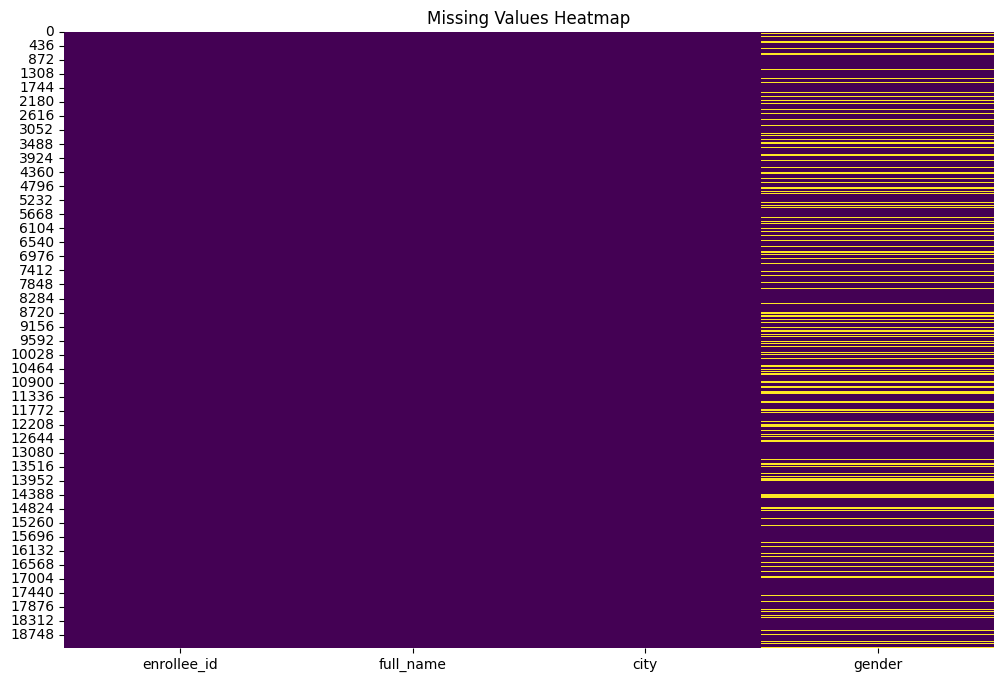

In [6]:
#enrollee
missing_value_analyzer = SimpleMissingValuesAnalysis()
missing_value_analyzer.analyze(enrollee)


Missing Values Count by Column:
enrolled_university     386
education_level         460
major_discipline       2813
dtype: int64

Visualizing Missing Values...


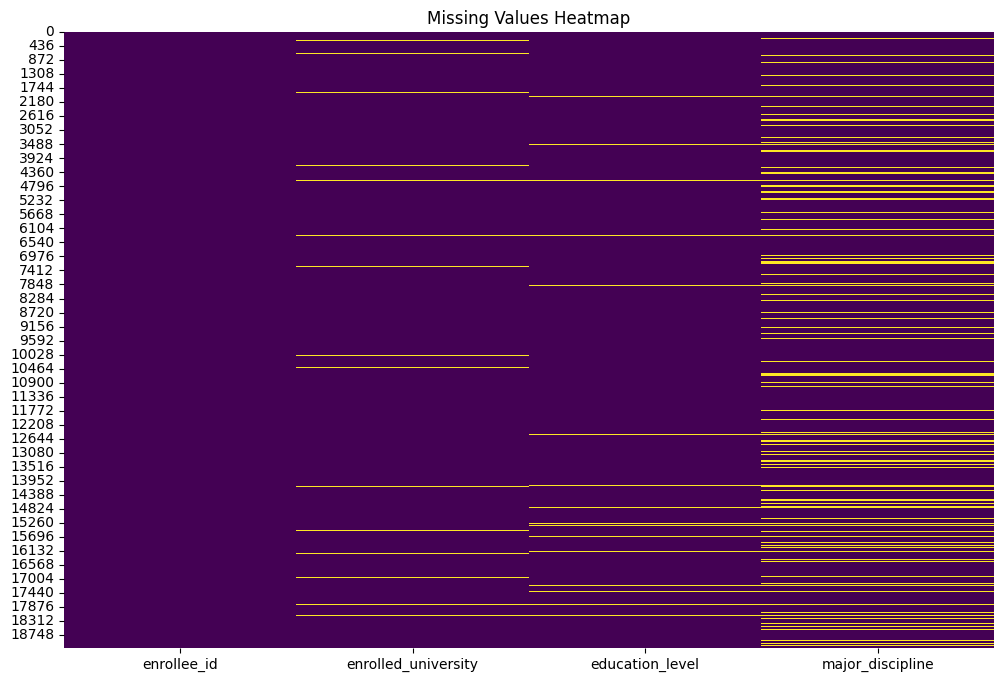

In [7]:
#enrollee_education
missing_value_analyzer = SimpleMissingValuesAnalysis()
missing_value_analyzer.analyze(enrollee_education)


Missing Values Count by Column:
Series([], dtype: int64)

Visualizing Missing Values...


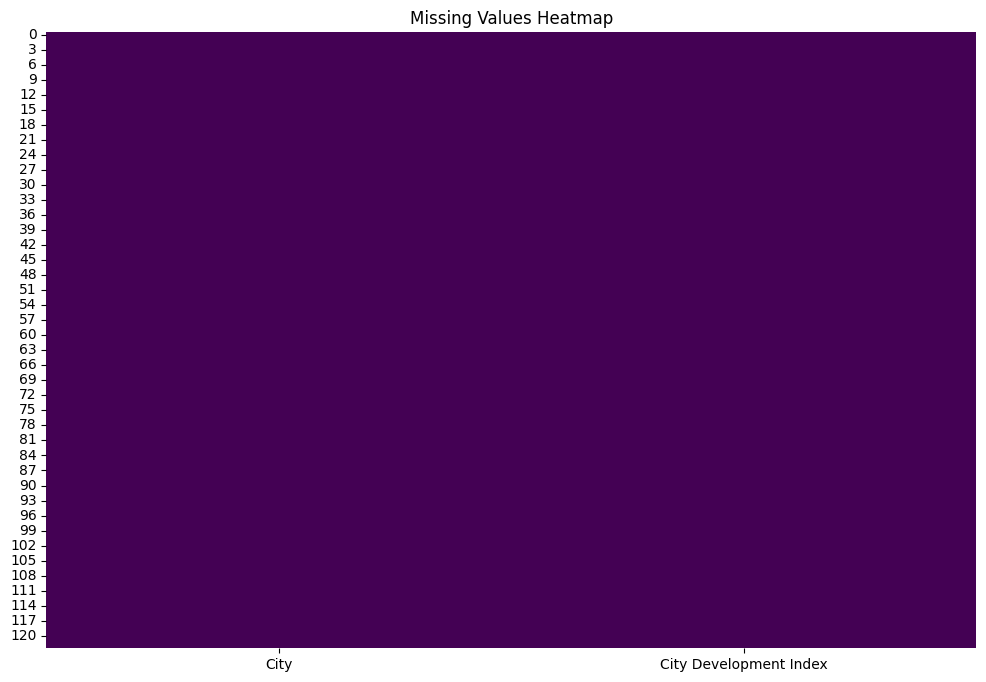

In [8]:
#city_dev_index
missing_value_analyzer = SimpleMissingValuesAnalysis()
missing_value_analyzer.analyze(city_dev_index[0])


Missing Values Count by Column:
Series([], dtype: int64)

Visualizing Missing Values...


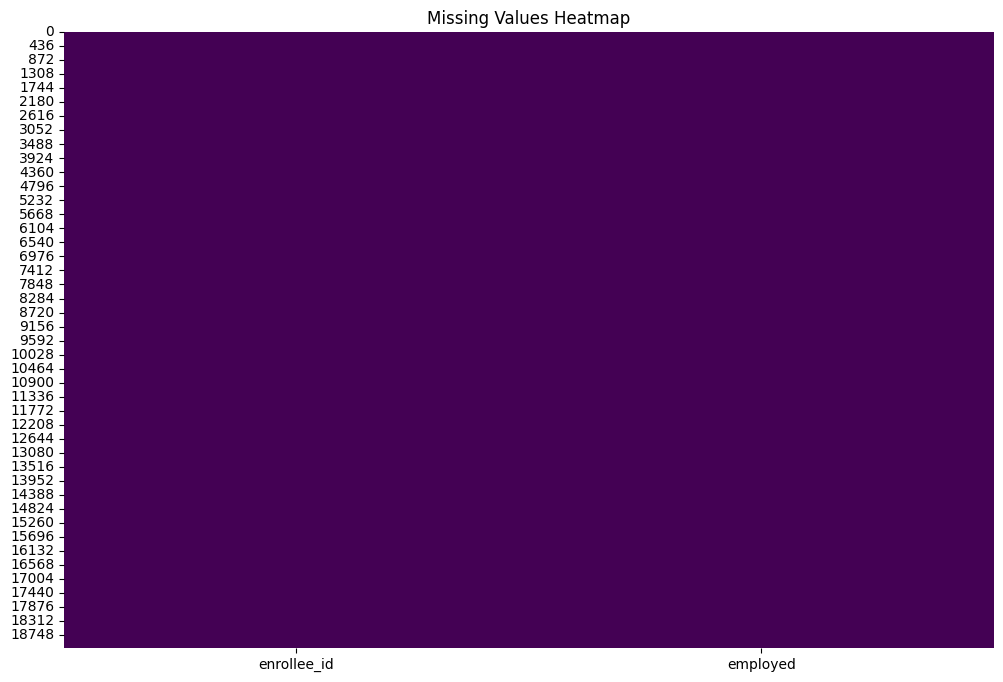

In [9]:
#employment
missing_value_analyzer = SimpleMissingValuesAnalysis()
missing_value_analyzer.analyze(employment)


Missing Values Count by Column:
Series([], dtype: int64)

Visualizing Missing Values...


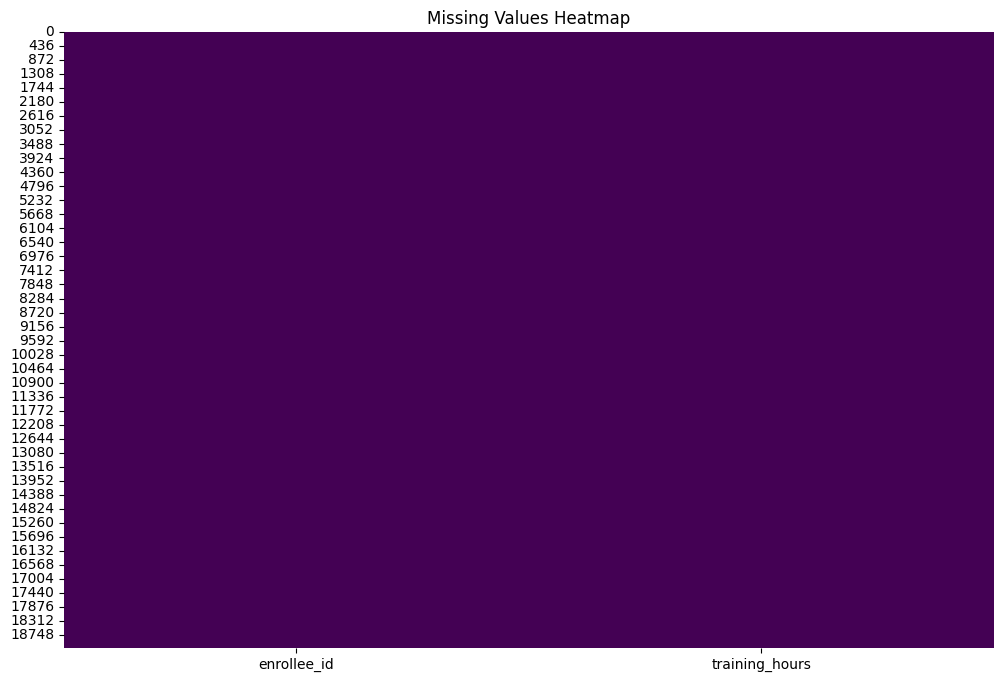

In [10]:
#training_hours
missing_value_analyzer = SimpleMissingValuesAnalysis()
missing_value_analyzer.analyze(training_hours)


Missing Values Count by Column:
experience        65
company_size    5938
company_type    6140
last_new_job     423
dtype: int64

Visualizing Missing Values...


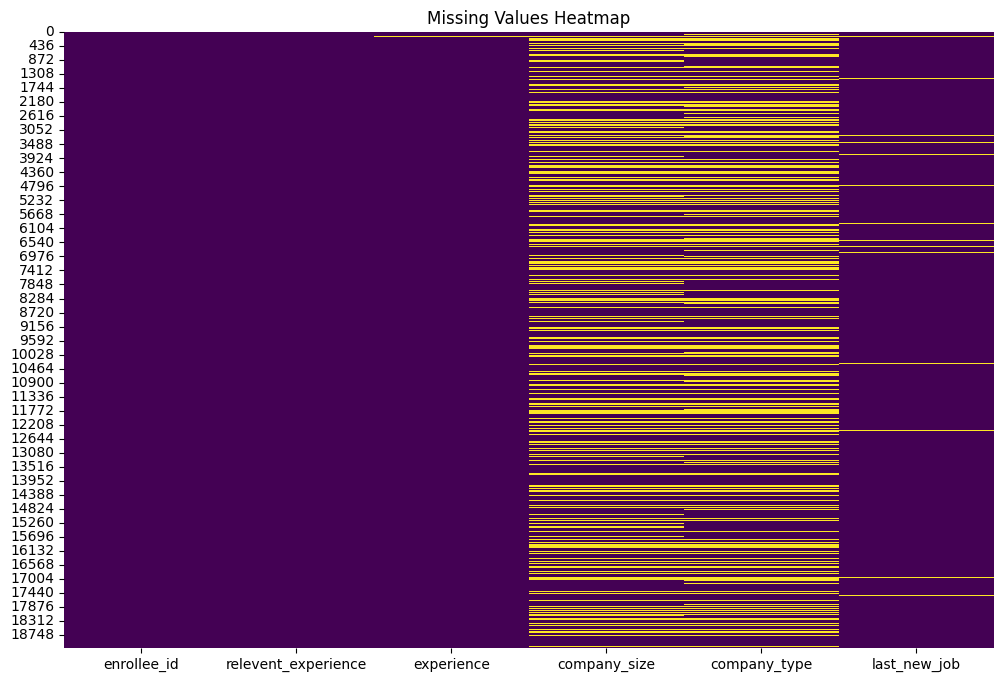

In [11]:
#work_experience
missing_value_analyzer = SimpleMissingValuesAnalysis()
missing_value_analyzer.analyze(work_experience)

ETL

CONVERT COLUMNS NAME IN CITY_DEV_INDEX

In [12]:
city_dev_index[0] = city_dev_index[0].rename(columns={"City":"city", "City Development Index": "city_development_index"})
city_dev_index[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    123 non-null    object 
 1   city_development_index  123 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.1+ KB


HANDLE MISSING VALUES FOR 3 DATASET (ENROLLEE, ENROLLEE_EDUCATION, WORK_EXPERIENCE)

2025-12-17 22:16:17,917 - INFO - Executing missing value handling strategy.
2025-12-17 22:16:17,918 - INFO - Filling missing values using method: constant
2025-12-17 22:16:17,923 - INFO - Missing values filled.



Missing Values Count by Column:
Series([], dtype: int64)

Visualizing Missing Values...


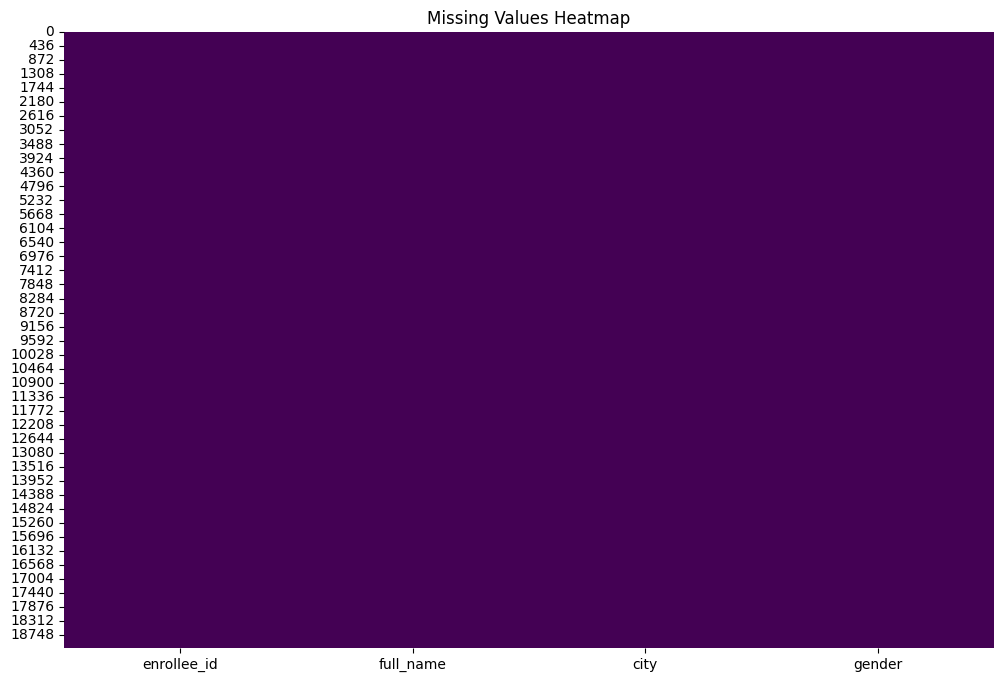

In [13]:
#Handle missing values of "enrollee"
#Filling missing values in the "Gender" column by using "Unknown"
missing_value_handler = MissingValueHandler(FillMissingValuesStrategy(method="constant", fill_value="Unknown"))
enrollee = missing_value_handler.handle_missing_values(enrollee)

missing_value_analyzer = SimpleMissingValuesAnalysis()
missing_value_analyzer.analyze(enrollee)

2025-12-17 22:16:18,259 - INFO - Executing missing value handling strategy.
2025-12-17 22:16:18,262 - INFO - Filling missing values using method: constant
2025-12-17 22:16:18,265 - INFO - Missing values filled.
2025-12-17 22:16:18,267 - INFO - Executing missing value handling strategy.
2025-12-17 22:16:18,268 - INFO - Filling missing values using method: constant
2025-12-17 22:16:18,273 - INFO - Missing values filled.



Missing Values Count by Column:
Series([], dtype: int64)

Visualizing Missing Values...


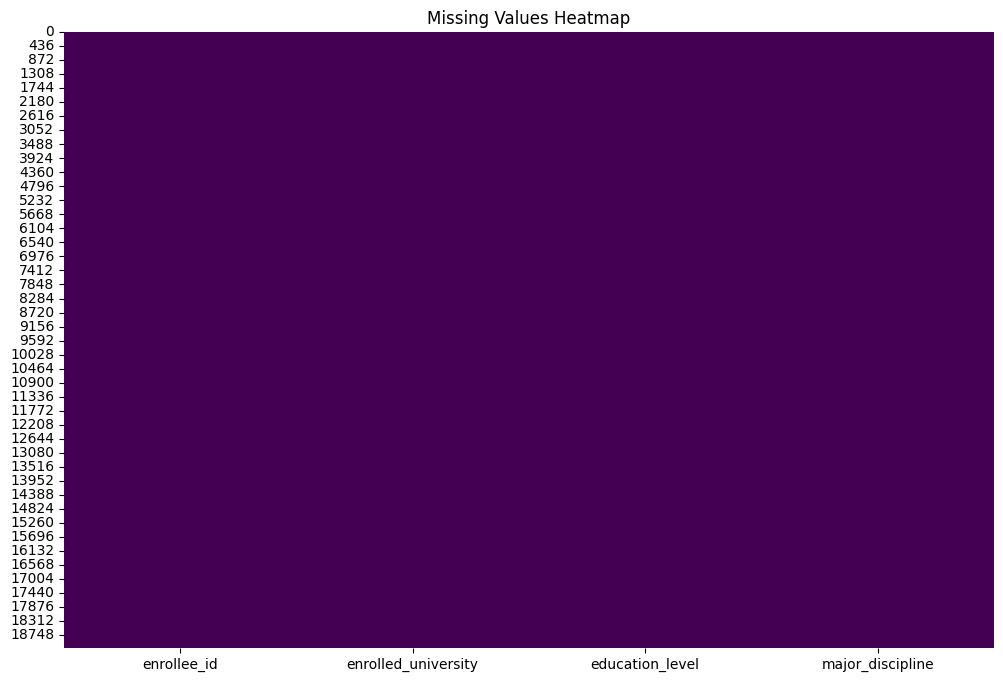

In [14]:
#Handle missing values of "enrollee_education"
#Filling missing values in the "enrolled_university" , "education_level" column by using "Unknown"
cols = ["enrolled_university" , "education_level"]

missing_value_handler = MissingValueHandler(FillMissingValuesStrategy(method="constant", fill_value="Unknown"))
enrollee_education[cols] = missing_value_handler.handle_missing_values(enrollee_education[cols])

#Filling missing values in the "major_discipline" column by using "Other"
missing_value_handler = MissingValueHandler(FillMissingValuesStrategy(method="constant", fill_value="Other"))
enrollee_education = missing_value_handler.handle_missing_values(enrollee_education)

missing_value_analyzer = SimpleMissingValuesAnalysis()
missing_value_analyzer.analyze(enrollee_education)

2025-12-17 22:16:18,652 - INFO - Executing missing value handling strategy.
2025-12-17 22:16:18,653 - INFO - Filling missing values using method: constant
2025-12-17 22:16:18,660 - INFO - Missing values filled.



Missing Values Count by Column:
Series([], dtype: int64)

Visualizing Missing Values...


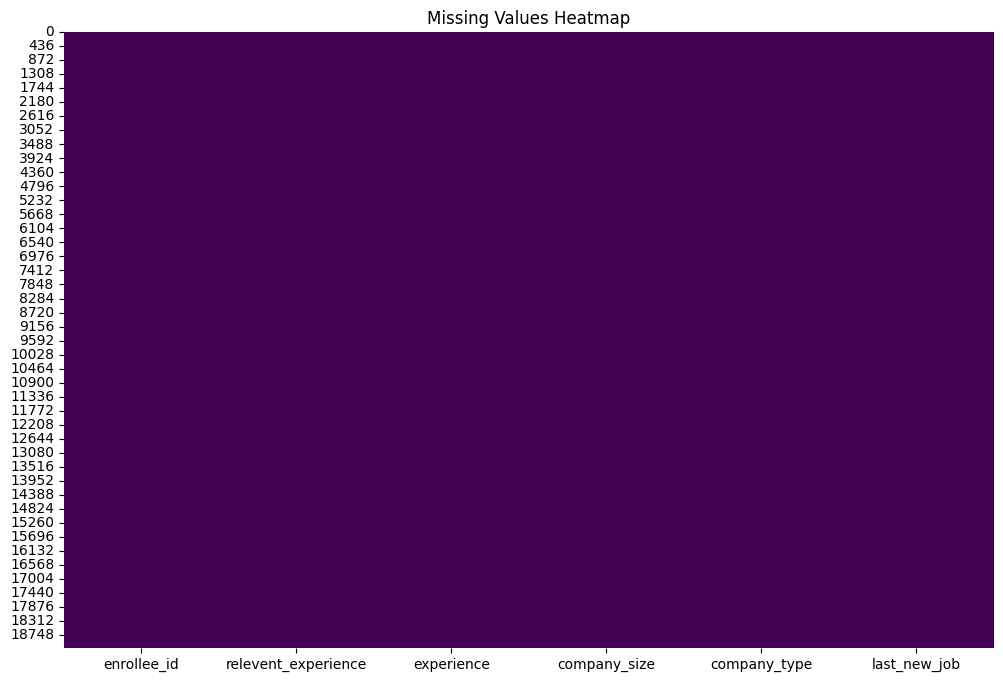

In [15]:
#Handle missing values of "work_experience"
#Filling missing values in the "enrolled_university" , "education_level" column by using "Unknown"
cols = ["company_size" , "company_type", "last_new_job", "experience"]

missing_value_handler = MissingValueHandler(FillMissingValuesStrategy(method="constant", fill_value="Unknown"))
work_experience[cols] = missing_value_handler.handle_missing_values(work_experience[cols])

missing_value_analyzer = SimpleMissingValuesAnalysis()
missing_value_analyzer.analyze(work_experience)

In [16]:
combined_data = enrollee.merge(enrollee_education,on="enrollee_id",how="right")
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   enrollee_id          19158 non-null  int64 
 1   full_name            19158 non-null  object
 2   city                 19158 non-null  object
 3   gender               19158 non-null  object
 4   enrolled_university  19158 non-null  object
 5   education_level      19158 non-null  object
 6   major_discipline     19158 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.0+ MB


In [17]:
combined_data = combined_data.merge(work_experience,on="enrollee_id",how="right")
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   enrollee_id          19158 non-null  int64 
 1   full_name            19158 non-null  object
 2   city                 19158 non-null  object
 3   gender               19158 non-null  object
 4   enrolled_university  19158 non-null  object
 5   education_level      19158 non-null  object
 6   major_discipline     19158 non-null  object
 7   relevent_experience  19158 non-null  object
 8   experience           19158 non-null  object
 9   company_size         19158 non-null  object
 10  company_type         19158 non-null  object
 11  last_new_job         19158 non-null  object
dtypes: int64(1), object(11)
memory usage: 1.8+ MB


In [18]:
combined_data = combined_data.merge(employment, on="enrollee_id", how="right")
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   enrollee_id          19158 non-null  int64  
 1   full_name            19158 non-null  object 
 2   city                 19158 non-null  object 
 3   gender               19158 non-null  object 
 4   enrolled_university  19158 non-null  object 
 5   education_level      19158 non-null  object 
 6   major_discipline     19158 non-null  object 
 7   relevent_experience  19158 non-null  object 
 8   experience           19158 non-null  object 
 9   company_size         19158 non-null  object 
 10  company_type         19158 non-null  object 
 11  last_new_job         19158 non-null  object 
 12  employed             19158 non-null  float64
dtypes: float64(1), int64(1), object(11)
memory usage: 1.9+ MB


In [19]:
combined_data = combined_data.merge(training_hours, on="enrollee_id", how="left")
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   enrollee_id          19158 non-null  int64  
 1   full_name            19158 non-null  object 
 2   city                 19158 non-null  object 
 3   gender               19158 non-null  object 
 4   enrolled_university  19158 non-null  object 
 5   education_level      19158 non-null  object 
 6   major_discipline     19158 non-null  object 
 7   relevent_experience  19158 non-null  object 
 8   experience           19158 non-null  object 
 9   company_size         19158 non-null  object 
 10  company_type         19158 non-null  object 
 11  last_new_job         19158 non-null  object 
 12  employed             19158 non-null  float64
 13  training_hours       19158 non-null  int64  
dtypes: float64(1), int64(2), object(11)
memory usage: 2.0+ MB


In [20]:
combined_data = combined_data.merge(city_dev_index[0], on="city", how="left")
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   full_name               19158 non-null  object 
 2   city                    19158 non-null  object 
 3   gender                  19158 non-null  object 
 4   enrolled_university     19158 non-null  object 
 5   education_level         19158 non-null  object 
 6   major_discipline        19158 non-null  object 
 7   relevent_experience     19158 non-null  object 
 8   experience              19158 non-null  object 
 9   company_size            19158 non-null  object 
 10  company_type            19158 non-null  object 
 11  last_new_job            19158 non-null  object 
 12  employed                19158 non-null  float64
 13  training_hours          19158 non-null  int64  
 14  city_development_index  19158 non-null

MACHINE LEARNING PIPELINE

GET RID OF THE REDUNDANT COLUMNS IN THE DATAFRAME

In [21]:
cols = ["enrollee_id", "full_name"]
combined_data = combined_data.drop(cols, axis=1)
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   gender                  19158 non-null  object 
 2   enrolled_university     19158 non-null  object 
 3   education_level         19158 non-null  object 
 4   major_discipline        19158 non-null  object 
 5   relevent_experience     19158 non-null  object 
 6   experience              19158 non-null  object 
 7   company_size            19158 non-null  object 
 8   company_type            19158 non-null  object 
 9   last_new_job            19158 non-null  object 
 10  employed                19158 non-null  float64
 11  training_hours          19158 non-null  int64  
 12  city_development_index  19158 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 1.9+ MB


In [22]:
#Input features (X) and Output features (y)
X = combined_data.drop(columns="employed")
y = combined_data["employed"]

In [23]:
#Splitting dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [24]:
#Splitting the numerical columns and the categorical columns
numerical_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

In [25]:
#Pipeline handle the numerical columns
numerical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
#Pipeline handle the categorical columns
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
#Put 2 Pipeline into 1 Workflow
preprocess = ColumnTransformer([
    ["num", numerical_transformer, numerical_cols],
    ["cat", categorical_transformer, categorical_cols]
])

In [26]:
#Defining models and its params
models = {
    "DecisionTree": Pipeline([
        ("prep", preprocess),
        ("clf", DecisionTreeClassifier(
            random_state=42,
            class_weight="balanced",
            max_depth=5
        ))
    ]),

    "RandomForest": Pipeline([
        ("prep", preprocess),
        ("clf", RandomForestClassifier(
            n_estimators=400,
            random_state=42,
            n_jobs=-1,
            class_weight="balanced_subsample"
        ))
    ])
}

In [27]:
#Evaluate models
#Declare the evaluatation performance function for models
def evaluate_classifier(y_true, y_pred, y_proba):
    return{
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba)
    }

In [28]:
#Training and evaluating models
rows, artifacts =  [], {}

for name, pipe in models.items():
    #Fit model
    pipe.fit(X_train, y_train)

    #Evaluate model
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    metrics = evaluate_classifier(y_test, y_pred, y_proba)
    rows.append({"Model":name, **metrics})

In [29]:
metrics_df = pd.DataFrame(rows).sort_values("roc_auc",ascending=True)
metrics_df

,Model,accuracy,precision,recall,f1,roc_auc
0,DecisionTree,0.766701,0.523884,0.700524,0.599462,0.78204
1,RandomForest,0.787578,0.596443,0.456545,0.517200,0.78982


In [30]:
models["DecisionTree"]

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[['num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['training_hours',
                                                   'city_development_index']],
                                                 ['cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['city', 'gender',
                                                   'enrolled_university',
                                                   'education_level',
                                                   'major_discipline',
                                                   'relevent_experience',
                                                   'experience', 'company_size',
                                                   'company_type',
                                                   'last_new_job']]])),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                                        random_state=42))])

In [31]:
models["RandomForest"]

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[['num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['training_hours',
                                                   'city_development_index']],
                                                 ['cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['city', 'gender',
                                                   'enrolled_university',
                                                   'education_level',
                                                   'major_discipline',
                                                   'relevent_experience',
                                                   'experience', 'company_size',
                                                   'company_type',
                                                   'last_new_job']]])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        n_estimators=400, n_jobs=-1,
                                        random_state=42))])

# ANALYZE THE IMPORTANCE OF THE FEATURES TO THE OUTPUT 

In [32]:
prep = models["DecisionTree"].named_steps["prep"]

final_est = models["DecisionTree"].named_steps["clf"]
importances = final_est.feature_importances_

#Retrieve the name of the column after preprocessing
num_cols = prep.transformers_[0][2]
one_hot_encoder = prep.named_transformers_["cat"].named_steps["onehot"]
cat_cols = prep.transformers_[1][2]
cat_names = list(one_hot_encoder.get_feature_names_out(cat_cols))

feat_name = list(num_cols) + cat_names

fi_df = pd.DataFrame({
    "feature_transformed": feat_name,
    "importance": importances
}).sort_values("importance", ascending=False)

fi_df.head()

,feature_transformed,importance
1,city_development_index,0.458511
177,company_size_Unknown,0.357513
132,education_level_Graduate,0.071431
191,last_new_job_never,0.031880
7,city_city_103,0.023469


In [33]:
for model_name, pipe in models.items():
    model_path = f"{model_name}.pkl"
    with open(model_path, "wb") as file: 
        pickle.dump(pipe, file)

# AI AGENT

In [34]:
#Extract sample data from the original dataset to test LLM Reasoning
# data_1 = combined_data[combined_data["employed"] == 1].head(10)
# data_0 = combined_data[combined_data["employed"] == 0].head(10)

# sample_data = pd.concat([data_0, data_1], axis=0, ignore_index=True)
# sample_data.info()

# sample_data.to_csv("sample_data.csv", index=False)

In [35]:
model_path = "DecisionTree.pkl"
with open(model_path, "rb") as file:
    loaded_model = pickle.load(file)

In [36]:
sample_data = pd.read_csv("sample_data.csv")
sample_data.info

<bound method DataFrame.info of     enrollee_id        full_name      city   gender enrolled_university  \
0             1  Emily Hernandez  city_103     Male       no_enrollment   
1             4     Chris Miller  city_103     Male       no_enrollment   
2             5     John Johnson   city_67     Male       no_enrollment   
3             7    Alex Martinez  city_136     Male    Full time course   
4             8       Alex Davis  city_103   Female       no_enrollment   
5            11    Mike Martinez  city_103     Male    Part time course   
6            13   Sarah Martinez  city_103     Male    Part time course   
7            17     Katie Miller   city_21  Unknown       no_enrollment   
8            18      David Brown   city_23     Male       no_enrollment   
9            19     Chris Garcia   city_23  Unknown    Part time course   
10            2       Alex Jones  city_103     Male       no_enrollment   
11            9   David Williams   city_16     Male       no_enrollm

In [37]:
#Declare AgentState
#When running explanation,the workflow of agent must be awared that its explanation is for what enrollee
class AgentState(TypedDict):
    enrollee_id: int
    enrollee_data: str
    probability: float
    employed_factors: dict
    explanation: str
    status: str

In [ ]:
#Setting up model AI and apply Prompt Engineer technique to instruct the Agent to use the tool
data_agent_key = ""

#Declare model
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.5, openai_api_key=data_agent_key)

feature_analysis_prompt = ChatPromptTemplate.from_messages([
    ("system", "Bạn là một chuyên gia phân tích dữ liệu. Dựa trên dữ liệu ứng viên và xác suất ứng viên tham gia vào làm cho công ty, hãy xác định các yếu tố hàng đầu ảnh hưởng đến việc học viên tham gia làm việc tại công ty sau khóa đào tạo. Đầu ra là một đối tượng JSON chứa tên các yếu tố và giá trị ảnh hưởng của chúng (tránh sử dụng ký tự đặc biệt)."),
    ("user", "Dữ liệu ứng viên: {enrollee_data}\nXác suất  ứng viên tham gia vào làm cho công ty: {probability}\nLiệt kê các yếu tố hàng đầu ảnh hưởng đến việc tham gia làm việc.")
])

In [39]:
#Tool 1: Retrieve enrollee data
def data_retrieval_tool(state: AgentState) -> AgentState:
    enrollee_id = state["enrollee_id"]
    enrollee_data = sample_data[sample_data["enrollee_id"] == enrollee_id]
    enrollee_data = enrollee_data.drop(columns=["employed"])
    probability = loaded_model.predict_proba(enrollee_data)[0][1]
    enrollee_data = enrollee_data.to_dict(orient="records")[0]
    return {"enrollee_data": enrollee_data, "status": "data_retrieved", "probability": probability}

In [40]:
#Tool 2: Analyzing the factors that affect to the ratio of result
#The more the result closed to "0": Enrollee have high potential to leave -> low probability of staying
#The more the result closed to "1": Enrollee have low potential to leave -> High probability of staying
def feature_analysis_agent(state: AgentState) -> AgentState:
    enrollee_data = state["enrollee_data"]
    probability = state["probability"]
    prompt = feature_analysis_prompt.format(enrollee_data=enrollee_data, probability=probability)
    response = llm.invoke([HumanMessage(content=prompt)])
    employed_factors = response.content
    return {"employed_factors": employed_factors, "status":"factors_identified"}

In [41]:
#Task, Content, Reference, Evaluate, Iterate => 5 steps to set up prompt

#Task: nhiem vu cua cong cu => 
"""Dua tren cac yeu to anh huong duoc cung cap, danh gia kha nang hoc vien tham gia lam viec tai cong ty sau khoa dao tao"""
#Context: cong cu duoc su dung trong truong hop nao, ngu canh su dung cong cu => 
"""Ban la mot chuyen gia nhan su"""
#Reference: cung cap thong tin bo sung de cong cu dua vao thuc hien Task => 
"""Neu xac suat < 0.5 -> hoc vien kho co kha nang tham gia lam viec tai cong ty -> Giai thich ly do, chi ra cac yeu to chinh va chi ra van de nam o dau. Neu xac suat >= 0.5 -> hoc vien co kha nang tham gia lam viec, hay lam noi bat cac diem manh khien cho hoc vien muon tham gia lam viec tai cong ty sau khoa dao tao. Giu loi giai thich ro rang, ngan gon"""
#Evaluate: danh gia hieu qua prompt
#Iterate: buoc lap lai (1->4)

explanation_prompt = ChatPromptTemplate.from_messages([
    ("system", """
    Ban la mot chuyen gia nhan su. 
    Dua tren cac yeu to anh huong duoc cung cap, danh gia kha nang hoc vien tham gia lam viec tai cong ty sau khoa dao tao.
    Neu xac suat < 0.5 -> hoc vien kho co kha nang tham gia lam viec tai cong ty -> Giai thich ly do, chi ra cac yeu to chinh va chi ra van de nam o dau.
    Neu xac suat >= 0.5 -> hoc vien co kha nang tham gia lam viec, hay lam noi bat cac diem manh khien cho hoc vien muon tham gia lam viec tai cong ty sau khoa dao tao.
    Giu loi giai thich ro rang, ngan gon"""),
    ("user", "Yếu tố ảnh hưởng: {employed_factors}\nXác suất tham gia làm việc: {probability}\nTạo lời giải thích.")
])

In [42]:
#Tool 3: Explanation
def explanation_agent(state: AgentState) -> AgentState:
    employed_factors = state["employed_factors"]
    probability = state["probability"]
    prompt = explanation_prompt.format(employed_factors=employed_factors, probability=probability)
    response = llm.invoke([HumanMessage(content=prompt)])
    explanation = response.content
    return {"explanation": explanation, "status": "explanation_generated"}

In [43]:
#Declare Agent Node
workflow = StateGraph(AgentState)
workflow.add_node("data_retrieval", data_retrieval_tool)
workflow.add_node("feature_analysis", feature_analysis_agent)
workflow.add_node("explanation_generator", explanation_agent)

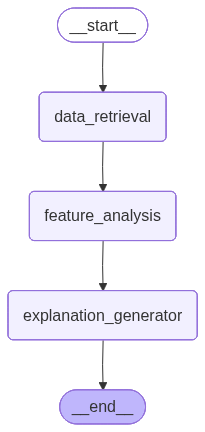

In [44]:
#Setting up connection between tools
workflow.add_edge(START, "data_retrieval")
workflow.add_edge("data_retrieval", "feature_analysis")
workflow.add_edge("feature_analysis", "explanation_generator")
workflow.add_edge("explanation_generator", END)
app = workflow.compile()
app

In [45]:
#Test AI Agent
result = app.invoke({"enrollee_id": 1, "status": "start"})
result

2025-12-17 22:16:32,997 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 22:16:35,511 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'enrollee_id': 1,
 'enrollee_data': {'enrollee_id': 1,
  'full_name': 'Emily Hernandez',
  'city': 'city_103',
  'gender': 'Male',
  'enrolled_university': 'no_enrollment',
  'education_level': 'High School',
  'major_discipline': 'Other',
  'relevent_experience': 'No relevent experience',
  'experience': '2',
  'company_size': 'Unknown',
  'company_type': 'Pvt Ltd',
  'last_new_job': 'never',
  'training_hours': 150,
  'city_development_index': 0.92},
 'probability': np.float64(0.17669225765675564),
 'employed_factors': '{\n  "experience": 0.325,\n  "education_level": 0.215,\n  "relevent_experience": 0.185,\n  "city_development_index": 0.145,\n  "training_hours": 0.13\n}',
 'explanation': 'Dựa vào các yếu tố ảnh hưởng như kinh nghiệm, trình độ học vấn, kinh nghiệm liên quan, chỉ số phát triển thành phố và số giờ đào tạo, xác suất tham gia làm việc của học viên sau khóa đào tạo là 0.176. Với xác suất này, học viên khó có khả năng tham gia làm việc tại công ty sau khóa đào tạo. Nguyên 

In [46]:
probabilities = []
employed_factors = []
explanations = []

for index, row in sample_data.iterrows():
    result = app.invoke({"enrollee_id": row["enrollee_id"], "status":"start"})

    probabilities.append(result["probability"])
    employed_factors.append(result["employed_factors"])
    explanations.append(result["explanation"])

sample_data["probability"] = probabilities
sample_data["factors"] = employed_factors
sample_data["explanations"] = explanations

2025-12-17 22:16:37,563 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 22:16:42,140 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 22:16:43,270 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 22:16:47,261 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 22:16:49,864 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 22:17:26,489 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 22:17:29,570 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 22:17:32,092 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-17 22:17:33,899 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

In [47]:
sample_data.to_excel("explanation_result.xlsx", sheet_name="Final Explanation", index=False)